<h2 style='color:DodgerBlue; font-family:Courier'>
This notebook puts together the equations for a fully connected neural network. We can make an N layer network, do the forward path to obtain predictions, do the backward path to obtain gradiants, and update parameters until we minimize the cost function. 
</h2>

In [1]:
# Importing the required libraries

import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# To have a smoother/faster convergance towards the minimum, all the features should be in a similar range. 
# This function scales each feature.

def feature_scaling(X):
    
    """
    input:
    X -- The input matrix of (m X n_features) where m is number of samples 
             and n_features is number of features.
    
    output:
    scaling_parameters -- a dictionary containig "mean" and "standard deviation" for each feature column.
    feature_scaled -- the input matrix normalized with its mean and std deviation
    """
    
    scaling_parameters = {}
    
    n_features = X.shape[1]
    scaling_parameters['mean'] = np.reshape(np.mean(X, axis=0),(1, n_features))
    scaling_parameters['std'] = np.reshape(np.std(X, axis=0),(1, n_features))
    X_scaled = (X - scaling_parameters['mean'])/scaling_parameters['std']
    
    return X_scaled, scaling_parameters    

In [3]:
# if our input is an image that is converted to its RGB values, then deviding by 255 is all we need
# to get all the pixles scaled between 0-1

def image_scaling(X):
    
    """
    input:
    X -- The input matrix of (m X n_pxl) where m is number of samples 
             and n_pxl is number of pixles. A 36x36 pixle image will have n_pxl = 1296.
    
    output:
    feature_scaled -- the normalized input matrix
    
    """
    
    X_scaled = X/255.0
    
    return X_scaled

In [4]:
def initialize_parameters_deep(layer_dims):
    
    """
    input:
    layer_dims -- python array (list) containing the dimensions of each layer in the network. 
                  An input with 200 features that is fed to a 2 layer networks with 10 and 1 nodes on each layer
                  will have layer_dims = [200, 10, 1]
    
    output:
    parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
    """
    
    np.random.seed(42)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    for l in range(1, L):
        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l])
        parameters['W' + str(l)] = parameters['W' + str(l)]/ np.amax(np.abs(parameters['W' + str(l)]))
        parameters['b' + str(l)] = np.zeros([1,layer_dims[l]])
                
    return parameters

<h3 style="font-family:courier; color:DodgerBlue"> Next, we will do the forward path to obtain final layer output, i.e. our predictions. All the inner layers will have Relu function as their activation function and the outside layer will have a sigmoid fuction. 
</h3>
<img src='./FW.png'style="width:50%; height:50%">

In [5]:
def L_model_forward(X, parameters):
    
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Inputs:
        X -- The input matrix of (m X n_features) where m is number of samples 
             and n_features is number of features.
        parameters -- a dictionary of parameters at each layer {'W1':[W1], 'b1':[b1], ...}
    
    Outputs:
        AL -- predictions, last post-activation array. For binary classification an array of (m X 1) size. 
        
        caches_Z -- every cache of linear A*W+b (there are L-1 of them, indexed from 0 to L-2)
        
        caches_A -- every cache of relu(Z) (there are L-1 of them, indexed from 0 to L-2)
                    the cache of sigmoid(Z) (there is one, indexed L-1)
        
        
    """

    caches_A = []
    caches_Z = []
    A = X
    caches_A.append(A)   # input to the network is indeed zeroth layer
    L = len(parameters) // 2                  # number of layers in the neural network-1
    
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        Wl = parameters['W'+str(l)]
        bl = parameters['b'+str(l)]
        Zl = np.matmul(A_prev, Wl)+ bl
        A = np.maximum(0, Zl)  # Relu function
        caches_A.append(A)
        caches_Z.append(Zl)

    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    WL = parameters['W'+str(L)]
    bL = parameters['b'+str(L)]
    A_prev = caches_A[-1]
    ZL = np.matmul(A_prev, WL)+ bL
    AL = sigmoid(ZL)
    caches_A.append(AL)
    caches_Z.append(ZL)

            
    return AL, caches_A, caches_Z

<h3 style="font-family:courier; color:DodgerBlue"> Gradiants, dW and dB, are computed in order to updated paramters. 
</h3>
<img src='./BW.png'style="width:80%; height:80%">

In [6]:
def L_model_backward(AL, Y, caches_A, caches_Z, parameters):
    
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Inputs:
        AL -- predictions, last post-activation array. For binary classification an array of (m X 1) size. 
        Y -- true "label" vector (containing 0 and 1 if binary classification)
        caches_A -- list of cached activation function containing: [A0,A1,A2,...]
                    
        caches_Z -- list of cached linear forward [Z1,Z2,...]
        
        parameters -- a dictionary of parameters at each layer {'W1':[W1], 'b1':[b1], ...}               
                
    Returns:
        grads -- A dictionary with the gradients
                 grads["dA" + str(l)] = ... 
                 grads["dZ" + str(l)] = ... 
                 grads["dW" + str(l)] = ...
                 grads["db" + str(l)] = ... 
    """
    
    grads = {}
    L = len(caches_Z) # the number of layers-1
    m = AL.shape[0]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = -np.divide(Y, AL)+ np.divide(1-Y, 1-AL) #won't need these as we are computting dZ. Just FYI
    dZL = np.multiply(dAL, np.multiply(AL, 1-AL))    # AL-Y # --> just for sigmoid function
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    grads["dA" + str(L)], grads["dZ" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = dAL, dZL, 1/m*np.matmul(caches_A[-2].T, dZL), np.mean(dZL, axis=0)
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        grads["dA" + str(l + 1)] = np.matmul(grads["dZ" + str(l + 2)], parameters['W' + str(l+2)].T)
        grads["dZ" + str(l + 1)] = np.multiply(grads["dA" + str(l + 1)], np.multiply(1, (caches_Z[l]>0).astype(int)))  # Relu deravitive
        grads["dW" + str(l + 1)] = 1/m*np.matmul(caches_A[l].T, grads["dZ" + str(l + 1)])
        grads["db" + str(l + 1)] = np.mean(grads["dZ" + str(l + 1)], axis=0)
        
    return grads

In [7]:
# update parameters with the calculated gradiants

def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L+1):
        parameters['W' + str(l)] = parameters['W' + str(l)]- learning_rate*grads['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)]- learning_rate*grads['db' + str(l)]
    
    return parameters

In [8]:
# Implements a L-layer neural network
    
    
def L_layer_model(X, Y, layers_dims, learning_rate = 0.1, num_iterations = 3, print_cost=False):#lr was 0.009
   
    """
    Inputs:
        X -- data, numpy array of shape (number of examples, num_features)
            for image classification: numpy array of shape (number of examples, num_px * num_px * 3)
        Y -- true "label" vector (containing 0 and 1), of shape (number of examples, 1)
        layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
        learning_rate -- learning rate of the gradient descent update rule
        num_iterations -- number of iterations of the optimization loop
        print_cost -- if True, it prints the cost every 100 steps
    
    Outputs:
        parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches_A, caches_Z = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = -1*np.multiply(Y, np.log(AL))- 1*np.multiply(1-Y, np.log(1-AL))
        cost = np.mean(cost, axis=0)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches_A, caches_Z, parameters)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [9]:
# calculates accuracy of the trained model

def calc_accuracy(X, Y, parameters):
    
    m = Y.shape[0]
    L = len(parameters) // 2                  # number of layers in the neural network
    A = X
    
    # Implement [LINEAR -> RELU]*(L-1). 
    for l in range(1, L):
        A_prev = A 
        Wl = parameters['W'+str(l)]
        bl = parameters['b'+str(l)]
        Zl = np.matmul(A_prev, Wl)+ bl
        A = np.maximum(0, Zl)

    # Implement LINEAR -> SIGMOID. 
    WL = parameters['W'+str(L)]
    bL = parameters['b'+str(L)]
    ZL = np.matmul(A, WL)+ bL
    AL = sigmoid(ZL)
    
    prediction = AL>0.5
    
    prediction_accuracy = np.mean((prediction==Y).astype(int), axis=0)
    
    return prediction_accuracy

<h3 style="font-family:courier; color:DodgerBlue"> In this part, we will test our model to draw boundaries between two sets of data.
Data plots courtesy of <a href="https://github.com/zixchen">Zixchen</a>.
</h3>


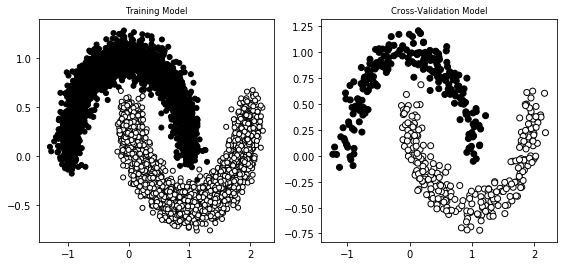

In [20]:

from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles


plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)

plt.subplot(221)
plt.title("Training Model", fontsize='small')

n_samples = 5000
train_size = 4500

X, Y = make_moons(n_samples=n_samples, shuffle=True, noise=0.1, random_state=42)

X1 = X[0:train_size,:]
Y1 = Y[0:train_size]

X2 = X[train_size:n_samples,:]
Y2 = Y[train_size:n_samples]

plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')
plt.subplot(222)
plt.title("Cross-Validation Model", fontsize='small')
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2,
            edgecolor='k')

In [14]:
# some data modifications

train_x_org = X1
train_y = Y1.reshape((Y1.size,1))
num_px = train_x_org.shape[1]
print('Training set input layer size: '+str(train_x_org.shape))
print('Training set output layer size: '+ str(train_y.shape))
m_train = train_x_org.shape[0]
# Reshape the training and test examples 
train_x_flatten = train_x_org.reshape(train_x_org.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
train_x, scalingParameters = feature_scaling(train_x_flatten)

CV_x_org = X2
CV_y = Y2.reshape((Y2.size,1))
print('CV set input layer size: '+str(CV_x_org.shape))
print('CV set output layer size: '+ str(CV_y.shape))
CV_x_flatten = CV_x_org.reshape(CV_x_org.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
CV_x = (CV_x_flatten-scalingParameters['mean'])/scalingParameters['std']



Training set input layer size: (4500, 2)
Training set output layer size: (4500, 1)
CV set input layer size: (500, 2)
CV set output layer size: (500, 1)


Cost after iteration 0: 0.662749
Cost after iteration 100: 0.232071
Cost after iteration 200: 0.024144
Cost after iteration 300: 0.007379
Cost after iteration 400: 0.004255
Cost after iteration 500: 0.003126
Cost after iteration 600: 0.002564
Cost after iteration 700: 0.002212
Cost after iteration 800: 0.001973
Cost after iteration 900: 0.001829


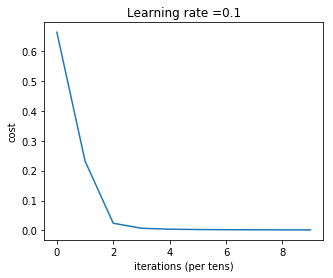

In [12]:
# Let's fit an 8-layer network 
parameters = L_layer_model(train_x, train_y, [2,10, 10, 10, 10, 10, 10, 10, 1], learning_rate = 0.1, num_iterations = 1000, print_cost=True)

In [17]:
# calculate accuracy of the trained and cross-validation models

print("Training accuracy is: "+ str(calc_accuracy(train_x, train_y, parameters)[0]))
print("Cross-Validation accuracy is: "+ str(calc_accuracy(CV_x, CV_y, parameters)[0]))


Training accuracy is: 0.999333333333
Cross-Validation accuracy is: 0.998


In [18]:
def predict_for_contour(X, parameters):
    m = X.shape[0]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((m,1))
    
    # Forward propagation
    AL, caches_A, caches_Z = L_model_forward(X, parameters)
    
    p = (AL>0.5).astype(dtype=np.float32)
    
    return p

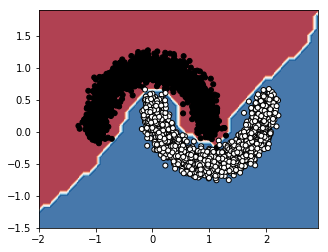

In [19]:
# Function to grid the working plane and evaluate trained model on each grid node

h = 0.1  # step size in the mesh
x_min, x_max = -2,3
y_min, y_max = -1.5,2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
test_x = np.stack((xx.flatten(),yy.flatten()), axis = 1)
test_x = (test_x - scalingParameters['mean'])/scalingParameters['std']

pred_test = predict_for_contour(test_x, parameters)
Z = pred_test.reshape(xx.shape[0],xx.shape[1])

ax = plt.subplot()
cm = plt.cm.RdBu

ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,s=25, edgecolor='k')